<a href="https://colab.research.google.com/github/stephenbeckr/numerical-analysis-class/blob/master/Demos/Ch4_GaussianQuadrature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Quadrature (specifically Gauss-Legendre)

- For an algorithm, see page 3 on ["Is Gauss Quadrature Better
than Clenshaw–Curtis?"](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.157.4174&rep=rep1&type=pdf) (Lloyd Trefethen, SIAM Review 50(1), 2008)
- Our class notes on this section are [Ch4_GaussianQuadrature.pdf](../Notes/Ch4_GaussianQuadrature.pdf)
- See also section 9.6 in [*Fundamentals of Numerical Computation*](https://tobydriscoll.net/project/fnc/) by Driscoll and Braun (2018, SIAM).

Here are their [core routines for interpolation/integration (ch 9)](https://github.com/tobydriscoll/fnc-extras/blob/master/python/FNC09.py) as well as their [jupyter notebook with demos](https://github.com/tobydriscoll/fnc-extras/blob/master/python/Chapter09.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tobydriscoll/fnc-extras/blob/master/python/Chapter09.ipynb)

If you run their notebook in colab, you may need to download files, using something like:

```
!curl -O https://raw.githubusercontent.com/tobydriscoll/fnc-extras/master/python/FNC[01-13].py
!curl -O https://raw.githubusercontent.com/tobydriscoll/fnc-extras/master/python/FNC.py
```


#### Major point
For Newton-Cotes, you **never** increase $n$ very large (beyond, say, 9). When you want more accuracy, you switch to a **composite Newton-Cotes** (so now, with the new meaning of $n$, it is OK to use a large $n$)

But for Gaussian quadrature, while you could do it in a composite form, you don't have to.  You can take very large $n$ with (non-composite) Gaussian quadrature

In [4]:
import numpy as np
from   timeit import timeit
import scipy.linalg
import scipy.integrate
from   scipy.special import roots_legendre
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = [8,6] # or 7, 4 or 10,8
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["lines.markersize"] = 4
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams.update({'font.size': 20})
def matprint(mat, fmt="g",roundToDecimal=None):
  # from https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
  # Modified to round
  if roundToDecimal is not None:
    mat = np.round(mat,decimals=roundToDecimal)
  col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
  for x in mat:
    for i, y in enumerate(x):
      print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
    print("")

In [1]:
!curl -O https://raw.githubusercontent.com/tobydriscoll/fnc-extras/master/python/FNC05.py
# !curl -O https://raw.githubusercontent.com/tobydriscoll/fnc-extras/master/python/FNC09.py
# from FNC05 import trapezoid
from FNC05 import intadapt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4950  100  4950    0     0  27049      0 --:--:-- --:--:-- --:--:-- 26902


### These are the composite rules we already saw
Taken from [Ch4_CompositeIntegration.ipynb](Ch4_CompositeIntegration.ipynb)

In [5]:
def CompositeMidpoint( f, a, b, n ):
  h   = (b-a)/(n+1)  # this is \tilde{h} in the notes
  nodes = np.arange( a+h/2, b, step=h)
  return h*np.sum(f(nodes))

def CompositeTrapezoidal( f, a, b, n):
  nodes, h = np.linspace(a,b,n+1,retstep=True)
  y  = f(nodes)
  return h*( np.sum(y) - (y[0]+y[-1])/2) # y[-1] is last element; in Matlab, this is y(end)

def CompositeSimpson( f, a, b, n):
  n = int(n/2)*2  # Make it even
  nodes, h = np.linspace(a,b,n+1,retstep=True)
  y = f(nodes)
  return h/3*( y[0] + 2*np.sum(y[2:n:2]) + 4*np.sum(y[1:n:2]) + y[-1] ) # in Matlab, it is a:step:b whereas in Python it is a:b:step and not inclusive of b

### Let's evaluate these on some functions

Integral I is 1.751


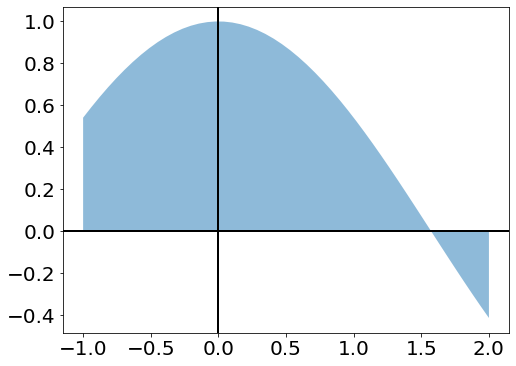

In [6]:
f = lambda x : np.cos(x)
F = lambda x : np.sin(x)  # dF/dx = f
a,b = -1,2


# Other examples to try
# f = lambda x : x**(3/2)
# F = lambda x : 2/5*x**(5/2)
# a,b = 0,1

# f = lambda x : 1/(1+x**2)  # aka Runge's function
# F = lambda x : np.arctan(x)
# a,b = -5,5

I   = F(b) - F(a)
print("Integral I is {:.3f}".format(I))

x = np.linspace(a,b)
plt.fill_between( x, f(x), alpha=0.5);
plt.axvline(color='k');
plt.axhline(color='k');

### Define the Gaussian quadrature rule
Driscoll and Braun call it `glint` for **G**auss-**L**egendre **Int**egration (recall that Gauss-*Legendre* is the basic form of Gaussian integration, but there are variants like *Chebyshev*-Gauss)

We'll go over the parts of this slowly

In [41]:
def glint(f,n,slowMode = False, specialMode = False):
    """
    glint(f,n)

    Perform Gauss-Legendre integration for the function `f` on `n` nodes in (-1,1). Return
    integral and a vector of the nodes used.
    """
    n = int(n)
    if specialMode:
      if slowMode:
        raise ValueError
      x,c = roots_legendre(n)
    else:
      # Nodes and weights are found via a tridiagonal eigenvalue problem.
      beta = 0.5/np.sqrt(1-(2.0*np.arange(1,n))**(-2)) # 3-term recurrence coeffs
      if slowMode:
        # Textbook style
        T = np.diag(beta,1) + np.diag(beta,-1)           # Jacobi matrix
        ev,V = scipy.linalg.eig(T)                       # eigenvalue decomposition
        ev = np.real_if_close(ev)                        # keep it real
      else:
        # Better
        ev,V = scipy.linalg.eigh_tridiagonal(np.zeros(n), beta)
    
      p = np.argsort(ev)                            # find indices that would sort ev
      x = ev[p]               # nodes (= Legendre points)
      c = 2*V[0,p]**2         # weights

    # Evaluate the integrand and compute the integral.
    # Note that we didn't need f until this point
    I = np.dot(c,f(x))         # vector inner product
    return I,x

In [23]:
#n = 5
n = int(1e3) # don't make larger than 2e3 or so...
%time I_fast,nodes = glint(f,n,slowMode = False)
%time I_slow,nodes = glint(f,n,slowMode = True)
%time I_special,nodes = glint(f,n,specialMode = True)
I_fast, I_slow, I_special, abs(I_fast-I_slow), abs(I_fast-I_special)

CPU times: user 80.6 ms, sys: 0 ns, total: 80.6 ms
Wall time: 81.4 ms
CPU times: user 3.88 s, sys: 1.5 s, total: 5.37 s
Wall time: 2.78 s
CPU times: user 76.5 ms, sys: 53.3 ms, total: 130 ms
Wall time: 66.1 ms


(1.6829419696157943,
 1.6829419696158145,
 1.6829419696159145,
 2.020605904817785e-14,
 1.2012613126444194e-13)

Interlude: comparing to Matlab

Matlab doesn't have nice tridiagonal eigenvalue solvers. To get something reasonably quick, you could use its sparse eigenvalue solvers. These are not perfect for triadiagonal matrices but are better than a generic eigenvalue solver.

You might notice that you get better performance via Matlab than via Python/Numpy/Scipy.  In theory, performance should be similar, because they all call the same LAPACK libraries, which in turn use BLAS libraries.

However, Matlab is commercial software and ships with the Intel MKL which provides a very high quality implementation of BLAS.  Numpy can be re-installed to work with Intel MKL, but you need Intel MKL, and must reinstall Numpy.  MKL does not appear to be available on Google's `colab`, so it uses `openblas`, which is a reasonable choice but likely not nearly as good as MKL.

In [11]:
np.show_config()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]


Let's explore the parts of that function

In [26]:
n = 7
beta = 0.5/np.sqrt(1-(2.0*np.arange(1,n))**(-2)) 
print("beta is", np.round(beta,decimals=3))

beta is [0.577 0.516 0.507 0.504 0.503 0.502]


In [14]:
T = np.diag(beta,1) + np.diag(beta,-1) 

print("T is:")
matprint(T,fmt='g',roundToDecimal=3)

T is:
    0  0.577      0      0      0      0      0  
0.577      0  0.516      0      0      0      0  
    0  0.516      0  0.507      0      0      0  
    0      0  0.507      0  0.504      0      0  
    0      0      0  0.504      0  0.503      0  
    0      0      0      0  0.503      0  0.502  
    0      0      0      0      0  0.502      0  


In [15]:
ev,V = scipy.linalg.eig(T)  
print("ev is", np.round(ev,decimals=3))
ev = np.real_if_close(ev)
print("Now ev is", np.round(ev,decimals=3))

ev is [-0.949+0.j -0.742+0.j -0.406+0.j  0.   +0.j  0.949+0.j  0.742+0.j
  0.406+0.j]
Now ev is [-0.949 -0.742 -0.406  0.     0.949  0.742  0.406]


In [17]:
print("Now ev is", np.round(ev,decimals=3))
p = np.argsort(ev)  # find indices that would sort ev
print(p)

Now ev is [-0.949 -0.742 -0.406  0.     0.949  0.742  0.406]
[0 1 2 3 6 5 4]


In [19]:
x = ev[p]               # nodes (= Legendre points)
c = 2*V[0,p]**2         # weights
print("Nodes are\t", np.round(x,decimals=3))
print("Weights are\t", np.round(c,decimals=3))

Nodes are	 [-0.949 -0.742 -0.406  0.     0.406  0.742  0.949]
Weights are	 [0.129 0.28  0.382 0.418 0.382 0.28  0.129]


In [27]:
# Scipy has a builtin code for this
# (which appears to use Newton's method, not a tridiagonal eigenvalue solve)
#https://github.com/scipy/scipy/blob/v1.5.2/scipy/special/orthogonal.py#L166
xx,cc = roots_legendre(n)
print("Nodes are\t", np.round(xx,decimals=3))
print("Weights are\t", np.round(cc,decimals=3))

Nodes are	 [-0.949 -0.742 -0.406  0.     0.406  0.742  0.949]
Weights are	 [0.129 0.28  0.382 0.418 0.382 0.28  0.129]


### That was for [-1,1], so translate to any [a,b]

In [42]:
def gauss(f,n,a,b, **kwargs):
  """
  gauss(f,n,a,b)

  Perform Gauss-Legendre integration of f on the interval [a,b]
  by transforming the input and calling glint(f,n)
  """
  # Follow equation (4.41) in Burden and Faires
  halfwidth = (b-a)/2
  midpoint  = (b+a)/2
  g = lambda t : halfwidth*f(halfwidth*t + midpoint)
  I,t = glint(g,n, **kwargs)  # The kwargs pass optional arguments through
  nodes = halfwidth*t + midpoint
  return I,nodes

### Test the code to make sure it works

In [35]:
for n in np.arange(1,12):
  I_est,nodes = gauss(f,n,a,b,slowMode=False,specialMode=False)
  print( f'Using {n:2d} nodes, error is {I-I_est:+.3e}' )

Using  1 nodes, error is -8.820e-01
Using  2 nodes, error is +4.512e-02
Using  3 nodes, error is -8.885e-04
Using  4 nodes, error is +9.189e-06
Using  5 nodes, error is -5.854e-08
Using  6 nodes, error is +2.529e-10
Using  7 nodes, error is -7.914e-13
Using  8 nodes, error is +1.110e-15
Using  9 nodes, error is -4.441e-16
Using 10 nodes, error is +3.109e-15
Using 11 nodes, error is -8.882e-16


### Let's take a look at node location

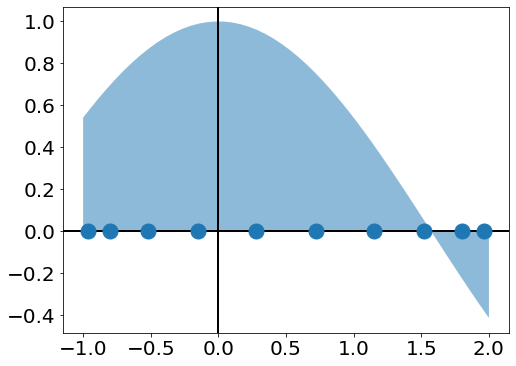

In [36]:
n = 10
I_est,nodes = gauss(f,n,a,b)
x = np.linspace(a,b)

plt.fill_between( x, f(x), alpha=0.5);
plt.axvline(color='k');
plt.axhline(color='k');

#plt.stem( nodes, f(nodes),use_line_collection=True);
plt.plot( nodes, 0*nodes, 'o',MarkerSize=15 );

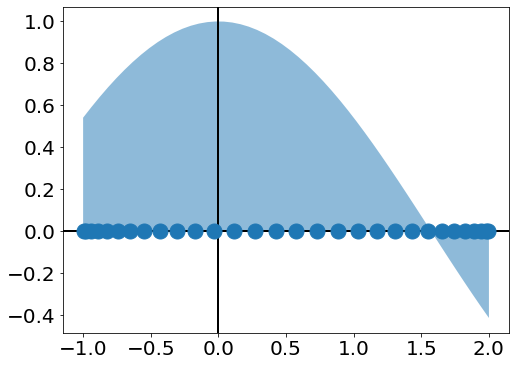

In [37]:
n = 30
I_est,nodes = gauss(f,n,a,b)
x = np.linspace(a,b)

plt.fill_between( x, f(x), alpha=0.5);
plt.axvline(color='k');
plt.axhline(color='k');

#plt.stem( nodes, f(nodes),use_line_collection=True);
plt.plot( nodes, 0*nodes, 'o',MarkerSize=15 );

### Switch to a harder function

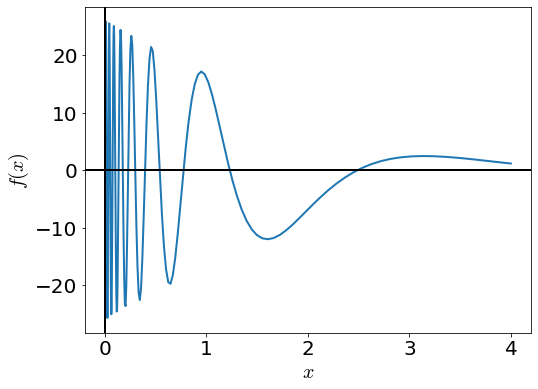

In [38]:
# A harder function
g = lambda x: (x+1)**2*np.cos((2*x+1)/(x-4.3))
f = lambda x: g(4.1-x) # transform it if we want
a,b = 0,4
I,errEstimate = scipy.integrate.quadrature(f,a,b,tol=1e-14,rtol=1e-14,maxiter=200)

x = np.logspace(-7,np.log10(b),500)
plt.plot(x,f(x))
plt.xlabel("$x$"); plt.ylabel("$f(x)$");
plt.axvline(color='k');
plt.axhline(color='k');

In [87]:
# Run Gaussian quadrature on this
for n in np.arange(1,100,step=10):
  I_est,nodes = gauss(f,n,a,b)
  print( f'Using {n:2d} nodes, error is {I-I_est:+.3e}' )

Using  1 nodes, error is +2.478e+01
Using 11 nodes, error is -5.850e+00
Using 21 nodes, error is -4.137e+00
Using 31 nodes, error is +9.016e-01
Using 41 nodes, error is -3.678e-01
Using 51 nodes, error is -2.021e-02
Using 61 nodes, error is +3.593e-04
Using 71 nodes, error is -1.172e-06
Using 81 nodes, error is -7.601e-09
Using 91 nodes, error is +9.093e-11


### For that hard function, systematically compare Gauss-Legendre with others
i.e., compare to the adaptive Simpson's `intadapt`, and regular composite Simpson's

In [43]:
# Q,t = intadapt(f,a,b,targetError)
errGauss = []
errAdaptive = []
errSimpson = []
nList = np.logspace(1,2,num=20,dtype=np.float)
for n in nList:
  I_est,nodes = gauss(f,n,a,b)
  errGauss.append( abs(I-I_est) )

nListSimp = np.logspace(1,5,num=40,dtype=np.float)
for n in nListSimp:
  I_est = CompositeSimpson( f, a, b, n)
  errSimpson.append( abs(I-I_est) )

tolList = np.logspace(-1,-15,num=20)
n_adaptive = []
for tol in tolList:
  I_est,nodes = intadapt(f,a,b,tol)
  n_adaptive.append( nodes.size )
  errAdaptive.append( abs(I-I_est) )


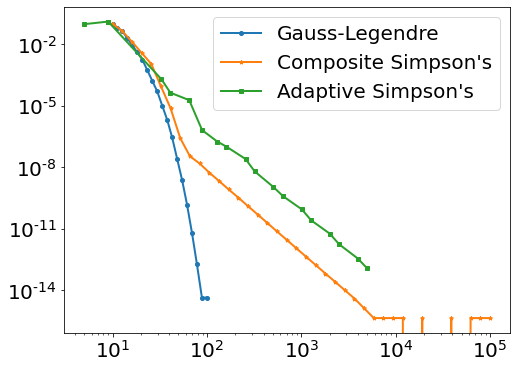

In [44]:
plt.loglog( nList, errGauss,'o-',label="Gauss-Legendre" );
plt.loglog( nListSimp, errSimpson,'*-',label="Composite Simpson's" );
plt.loglog( n_adaptive, errAdaptive,'s-',label="Adaptive Simpson's" );
plt.legend();

### Yet another function, and look at where the error is

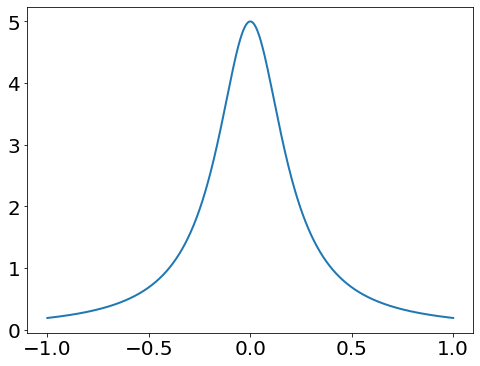

In [59]:
c = 5
f = lambda x : c/(1+(c*x)**2)  # aka Runge's function
F = lambda x : np.arctan(c*x)
a,b = -1,1  # so that we don't have to adjust
I = F(b) - F(a)

x = np.linspace(a,b,num=1000)
plt.plot( x, f(x) );

Now we can look at interpolating this with either **uniformly spaced nodes** or with **Gauss-Legendre nodes** (e.g., the zeros of the nth Legendre polynomial).

All that changes are the node locations: given node locations, the interpolating polynomial is decided

We can also compare with Chebyshev nodes (aka Chebyshev extreme points; these are zeros of the Chebyshev polynomials of the 2nd kind), which are almost as good as Gauss-Legendre and are simpler to compute.

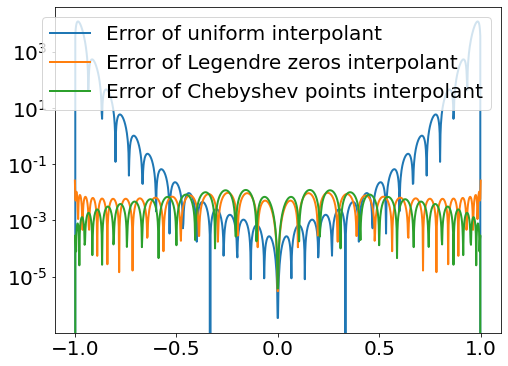

In [65]:
from scipy.interpolate import BarycentricInterpolator

n = 30
nodes = np.linspace(a,b,n+1) # uniform
uniformInterpolant = BarycentricInterpolator(nodes,f(nodes))

nodes,weights = roots_legendre(n+1)
GaussInterpolant = BarycentricInterpolator(nodes,f(nodes))

nodes = -np.cos( np.pi*np.arange(0,n+1)/n)
ChebyshevInterpolant = BarycentricInterpolator(nodes,f(nodes))

x = np.linspace(a,b,num=1000)
plt.semilogy( x, abs( f(x) - uniformInterpolant(x) ), label="Error of uniform interpolant");
plt.semilogy( x, abs( f(x) - GaussInterpolant(x) ), label="Error of Legendre zeros interpolant");
plt.semilogy( x, abs( f(x) - ChebyshevInterpolant(x) ), label="Error of Chebyshev points interpolant");
plt.legend()